# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

[Скачать данные](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip)

| Наименование столбца   | Описание |
|------------------------|----------|
| work_year              | Год, в котором была выплачена зарплата. |
| experience_level       | Опыт работы на этой должности в течение года:<br>• EN — Entry-level/Junior;<br>• MI — Mid-level/Intermediate;<br>• SE — Senior-level/Expert;<br>• EX — Executive-level/Director. |
| employment_type        | Тип трудоустройства для этой роли:<br>• PT — неполный рабочий день;<br>• FT — полный рабочий день;<br>• CT — контракт;<br>• FL — фриланс. |
| job_title              | Роль, в которой соискатель работал в течение года. |
| salary                 | Общая выплаченная валовая сумма заработной платы. |
| salary_currency        | Валюта выплачиваемой заработной платы (код валюты ISO 4217). |
| salary_in_usd          | Зарплата в долларах США (с учётом курса доллара за соответствующий год). |
| employee_residence     | Основная страна проживания сотрудника (код страны ISO 3166). |
| remote_ratio           | Объём работы, выполняемой удалённо:<br>• 0 — удалённой работы нет (менее 20 %);<br>• 50 — частично удалённая работа;<br>• 100 — полностью удалённая работа (более 80 %). |
| company_location       | Страна главного офиса работодателя или филиала по контракту (код страны ISO 3166). |
| company_size           | Среднее количество сотрудников компании:<br>• S — менее 50 сотрудников;<br>• M — 50–250 сотрудников;<br>• L — более 250 сотрудников. |

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
- тест для категориальных признаков.


# 0. Загрузка данных

In [169]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import country_converter as coco

import warnings
warnings.filterwarnings('ignore')

In [71]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


# 1. Описательный анализ данных

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений). Первый столбец неинформативный и можем его удалить.

Кроме того, у нас имеется признак зарплаты в долларах США по курсу соответствующего года `salary_in_usd`, а значит признаки общей  выплаченной зарплаты `salary` и валюта `salary_currency` повторяют те же данные и неинформативны, их тоже можем удалить.

Целевая переменная `salary_in_usd` - численный признак.

Год работы `work_year` и общий объём работы, выполняемой удалённо `remote_ratio` также представлены в числовом виде, но для исследования их удобно использовать как категориальные.

Проверим данные на наличие полных дубликатов:

In [73]:
data = data.iloc[:, 1:]
data = data.drop(['salary', 'salary'], axis=1)

print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 10)


## 1.1. Распределение заработной платы по всем специалистам

Посмотрим распределение зарплат для всех специалистов в долларах США (с учётом курса доллара за соответствующий год)

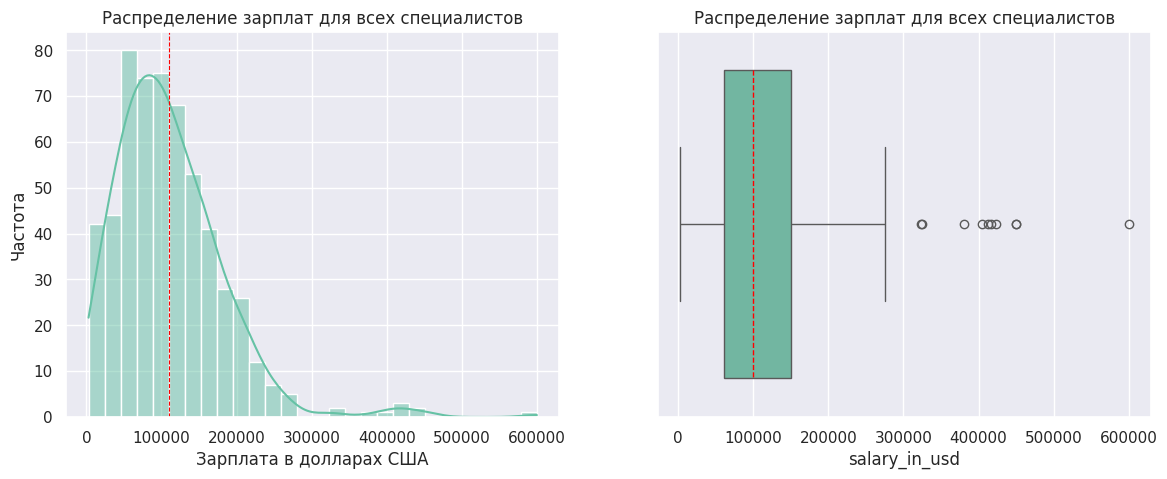

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплат для всех специалистов')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_title('Распределение зарплат для всех специалистов')

plt.show()

In [14]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат в долларах США']
data_agg

,Размер зарплат в долларах США
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение не похоже на нормальное, имеются выбросы, среднее значение и медиана различаются

In [ ]:
# напишу функцию для вывода описательных статистик зависимостей с целевой переменной

def explore_categorical_salary_doubleplot(df, cat_features, target='salary_in_usd', top_n=5):
    """
    Визуализация зависимости зарплаты от категориальных признаков.

    Для каждого категориального признака строится два графика рядом:
    - barplot с количеством наблюдений в каждой категории;
    - boxplot с распределением целевой переменной (зарплаты) в зависимости от категории.

    Если число уникальных значений признака превышает `top_n`, то оставшиеся 
    категории объединяются в категорию "Other". Категории на графиках сортируются 
    по медиане зарплаты.

    Параметры
    ----------
    df : pandas.DataFrame
        Исходный DataFrame с данными.
    cat_features : list of str
        Список категориальных признаков, для которых нужно построить визуализацию.
    target : str, optional, default='salary_in_usd'
        Название целевой переменной (например, зарплата в долларах).
    top_n : int, optional, default=5
        Количество наиболее частых категорий, которые остаются отдельными.
        Все остальные объединяются в "Other".

    Вывод
    -----
    None
        Функция выводит:
        - сводную статистику (`count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`) 
          по целевой переменной для каждой категории;
        - два графика (barplot и boxplot) для каждой категориальной переменной.
    """
    df_copy = df.copy()
    
    # Преобразуем remote_ratio в категорию, если он есть и числовой
    if 'remote_ratio' in cat_features and df_copy['remote_ratio'].dtype != 'O':
        df_copy['remote_ratio'] = df_copy['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })
    
    # Преобразуем work_year в категорию (строку), если он есть и числовой
    if 'work_year' in cat_features and df_copy['work_year'].dtype != 'O':
        df_copy['work_year'] = df_copy['work_year'].astype(str)

    for cat in cat_features:
        print(f"\nКатегория: {cat}")
        
        # Проверяем количество уникальных категорий
        n_unique = df_copy[cat].nunique()
        
        if n_unique > top_n:
            # Берём топ-N категорий по частоте, остальные → "Other"
            top_categories = df_copy[cat].value_counts().nlargest(top_n).index
            df_copy[cat] = df_copy[cat].apply(lambda x: x if x in top_categories else 'Other')
        
        # Сводная статистика
        data_agg = df_copy.groupby(cat)[target].describe().round(2)
        print(data_agg)
        
        # Сортировка категорий по медиане зарплаты
        order = df_copy.groupby(cat)[target].median().sort_values().index.tolist()
        
        # Создаём 2 графика рядом
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # --- Barplot (кол-во людей) ---
        counts = df_copy[cat].value_counts().reindex(order)
        sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
        axes[0].set_title(f'Количество людей по {cat}')
        axes[0].set_ylabel('Количество')
        axes[0].set_xlabel('')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Подписи над столбцами
        for i, v in enumerate(counts.values):
            axes[0].text(i, v + 1, str(v), ha='center', va='bottom')
        
        # --- Boxplot (зарплаты) ---
        sns.boxplot(x=target, y=cat, data=df_copy, order=order, ax=axes[1])
        axes[1].set_title(f'Зарплата в зависимости от {cat}')
        axes[1].set_xlabel(target)
        axes[1].set_ylabel('')
        
        plt.tight_layout()
        plt.show()



Категория: work_year
           count       mean       std      min      25%       50%       75%  \
work_year                                                                     
2020        72.0   95813.00  82831.80   5707.0  45724.5   75544.0  115526.0   
2021       215.0   99430.41  80304.32   2859.0  50000.0   82528.0  135000.0   
2022       278.0  123089.10  59888.93  10000.0  78791.0  120000.0  160000.0   

                max  
work_year            
2020       450000.0  
2021       600000.0  
2022       405000.0  


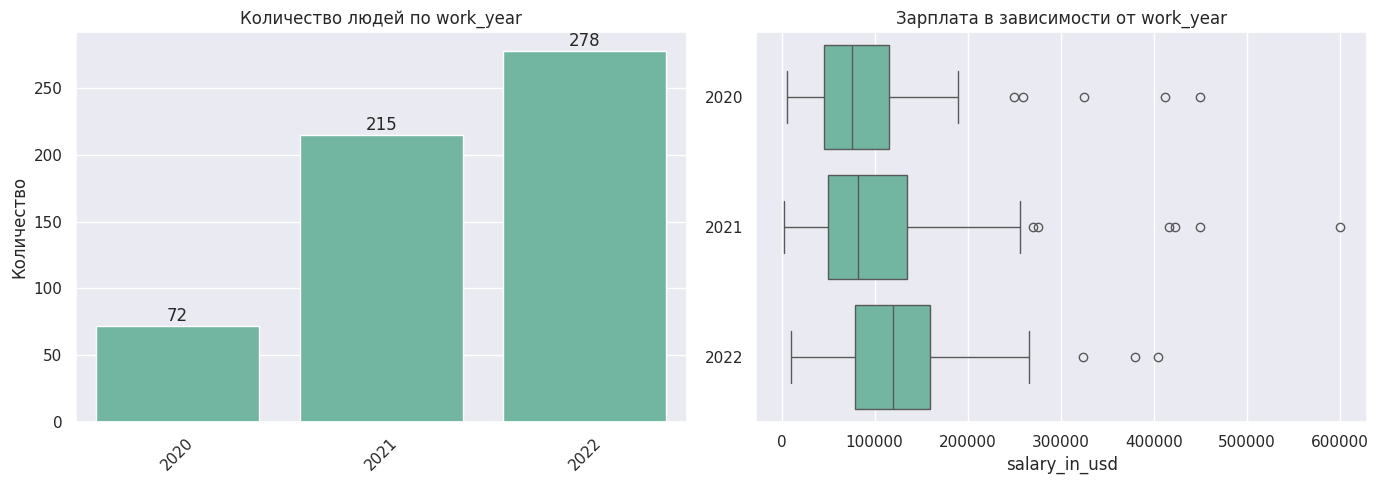


Категория: experience_level
                  count       mean        std      min        25%       50%  \
experience_level                                                              
EN                 88.0   61643.32   44395.54   4000.0   27505.00   56500.0   
EX                 26.0  199392.04  117071.26  69741.0  130006.50  171437.5   
MI                208.0   87793.00   64118.97   2859.0   47163.75   76940.0   
SE                243.0  138374.88   59955.97  18907.0   99531.50  135000.0   

                        75%       max  
experience_level                       
EN                 85425.75  250000.0  
EX                233750.00  600000.0  
MI                112075.00  450000.0  
SE                171881.00  412000.0  


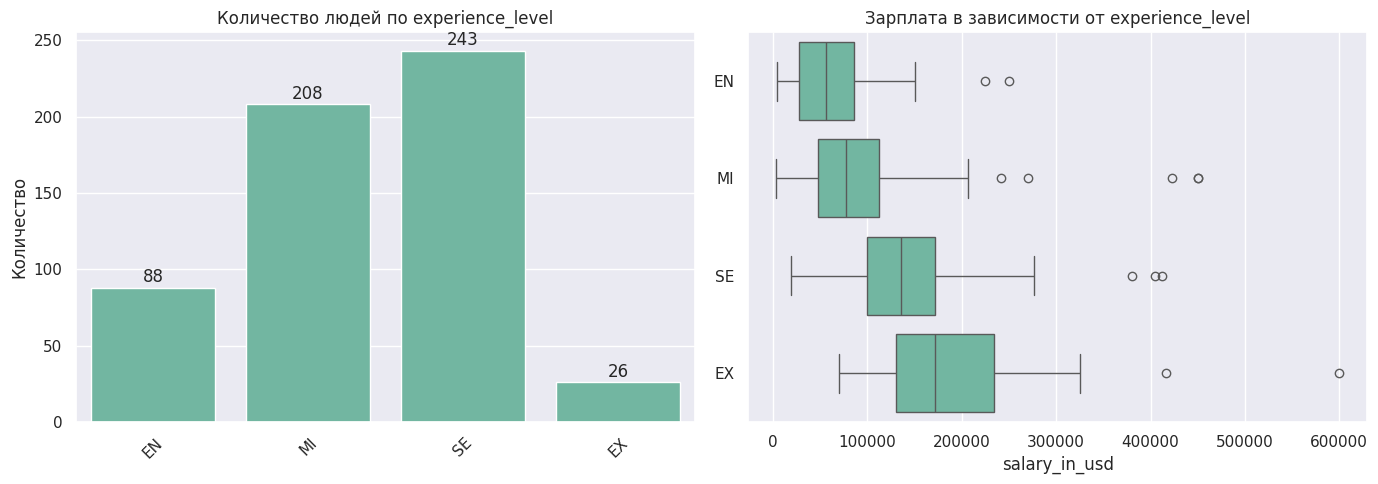


Категория: employment_type
                 count       mean        std      min       25%       50%  \
employment_type                                                             
CT                 5.0  184575.00  156250.89  31875.0  100000.0  105000.0   
FL                 4.0   48000.00   40529.82  12000.0   18000.0   40000.0   
FT               546.0  111811.84   70790.70   2859.0   62726.0  100000.0   
PT                10.0   33070.50   31472.91   5409.0   12000.0   18817.5   

                      75%       max  
employment_type                      
CT               270000.0  416000.0  
FL                70000.0  100000.0  
FT               150000.0  600000.0  
PT                48370.0  100000.0  


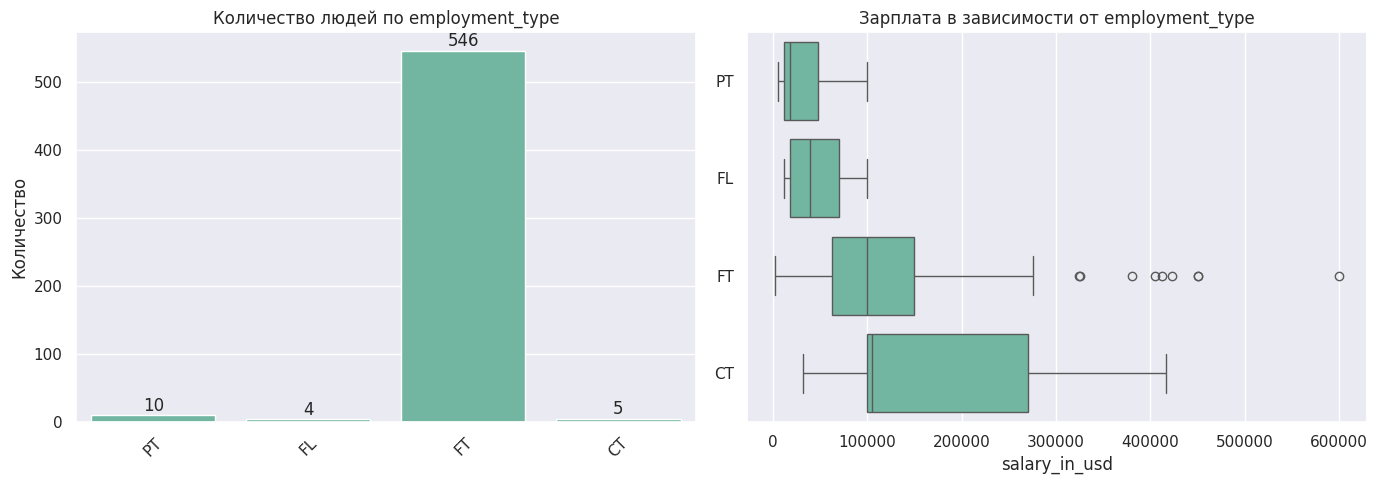


Категория: job_title
                           count       mean       std      min       25%  \
job_title                                                                  
Data Analyst                82.0   90089.60  40686.26   6072.0  60325.00   
Data Engineer              121.0  109750.03  58203.68   4000.0  66022.00   
Data Scientist             130.0  103336.35  63967.56   2859.0  50330.25   
Machine Learning Engineer   39.0  101165.13  62518.56  20000.0  49173.00   
Other                      177.0  128272.68  91817.00   5409.0  61896.00   
Research Scientist          16.0  109019.50  98542.76  42000.0  62176.00   

                                50%       75%       max  
job_title                                                
Data Analyst                90000.0  116112.5  200000.0  
Data Engineer              100800.0  150000.0  324000.0  
Data Scientist             100000.0  140400.0  412000.0  
Machine Learning Engineer   87425.0  131500.0  250000.0  
Other                

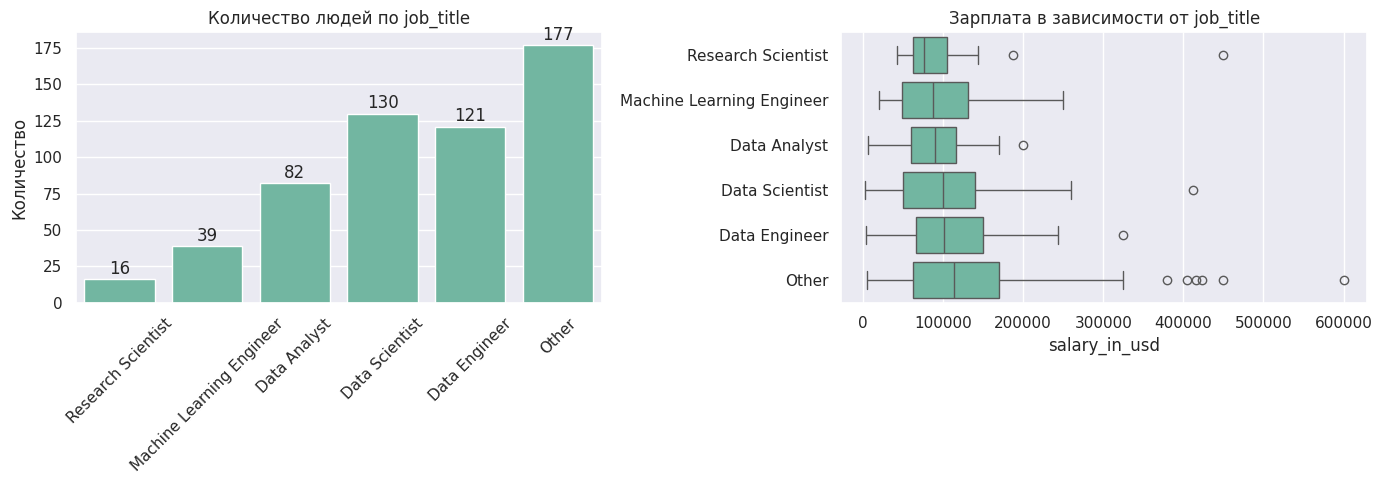


Категория: employee_residence
                    count       mean       std      min        25%       50%  \
employee_residence                                                             
CA                   27.0   97191.63  40151.79  52000.0   71349.00   85000.0   
DE                   24.0   85336.67  40215.64  15966.0   62411.25   78015.0   
GB                   43.0   81470.07  30283.75  37300.0   55247.00   78526.0   
IN                   30.0   37322.33  43741.19   5409.0   16397.00   22124.0   
Other               146.0   61107.58  42289.12   2859.0   34030.75   52256.5   
US                  295.0  150094.92  70918.56  25000.0  105200.00  138000.0   

                          75%       max  
employee_residence                       
CA                  110397.50  196979.0  
DE                   94859.50  173762.0  
GB                  103931.00  183228.0  
IN                   38812.75  200000.0  
Other                77258.00  260000.0  
US                  175550.00  600

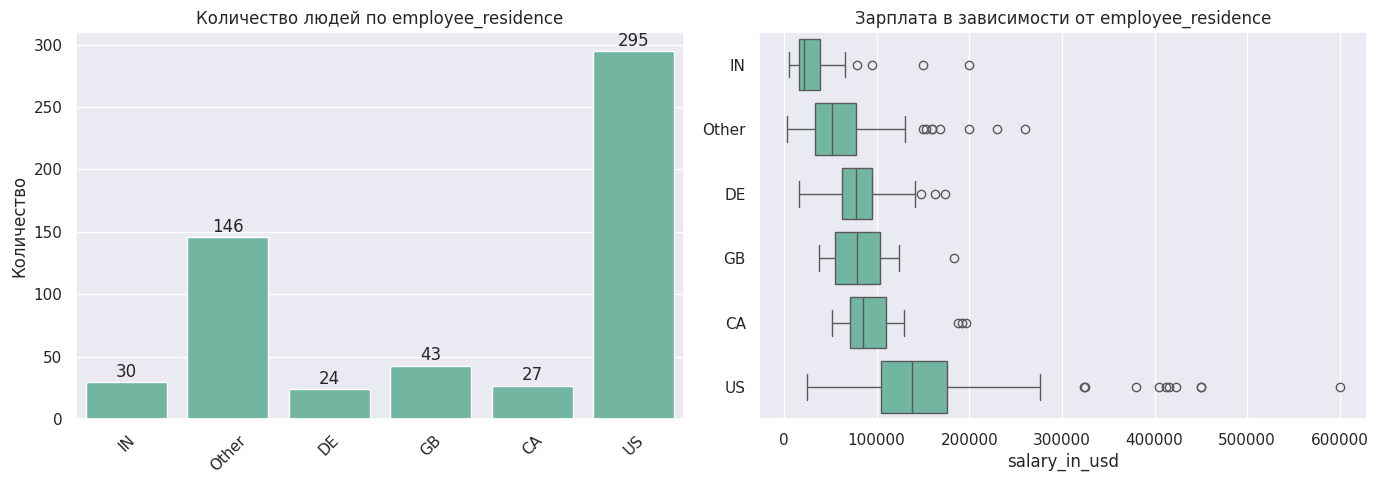


Категория: company_location
                  count       mean       std      min       25%       50%  \
company_location                                                            
CA                 28.0  100121.86  47080.71  52000.0   70518.0   81895.5   
DE                 27.0   81559.56  39903.44  15966.0   58669.0   76833.0   
GB                 46.0   81649.50  29846.70  37300.0   56915.5   78526.0   
IN                 24.0   28581.75  22697.67   5409.0   16735.0   22124.0   
Other             122.0   58707.48  41730.40   2859.0   32974.0   50090.0   
US                318.0  144292.99  72524.34   5679.0  100000.0  135000.0   

                        75%       max  
company_location                       
CA                117374.75  225000.0  
DE                 89694.00  173762.0  
GB                104316.50  183228.0  
IN                 32163.25   94665.0  
Other              76237.50  260000.0  
US                173000.00  600000.0  


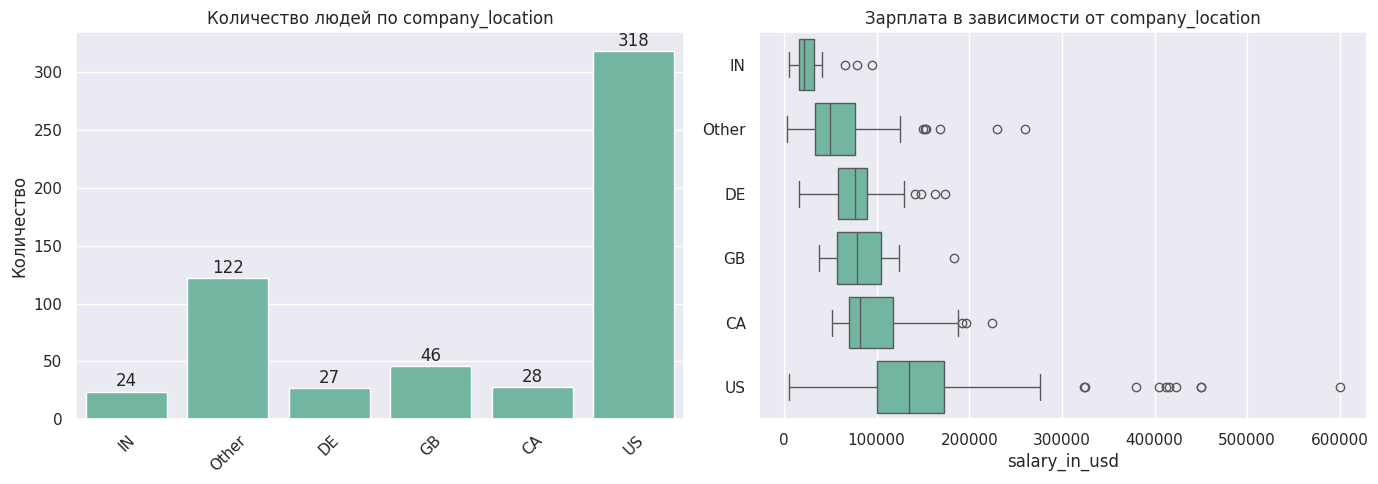


Категория: company_size
              count       mean       std     min      25%       50%  \
company_size                                                          
L             193.0  118213.88  86753.27  5882.0  60000.0  100000.0   
M             290.0  114807.08  60779.04  4000.0  70821.5  109640.0   
S              82.0   77872.10  63814.52  2859.0  41816.0   65511.0   

                    75%       max  
company_size                       
L             153667.00  600000.0  
M             150213.75  450000.0  
S             100000.00  416000.0  


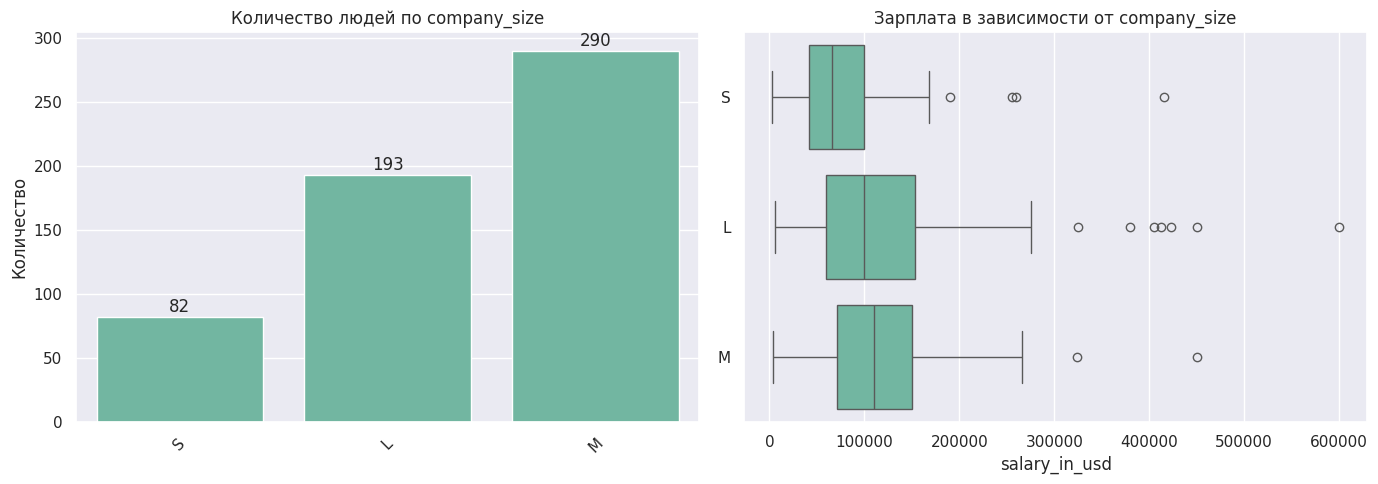


Категория: remote_ratio
               count       mean       std     min      25%       50%  \
remote_ratio                                                           
Hybrid (50%)    98.0   80721.90  57639.10  5409.0  50000.5   68010.5   
On-site (0%)   121.0  105785.40  68392.50  2859.0  62000.0   98158.0   
Remote (100%)  346.0  120763.19  74930.43  4000.0  70000.0  110712.5   

                     75%       max  
remote_ratio                        
Hybrid (50%)    99925.75  423000.0  
On-site (0%)   136000.00  450000.0  
Remote (100%)  159750.00  600000.0  


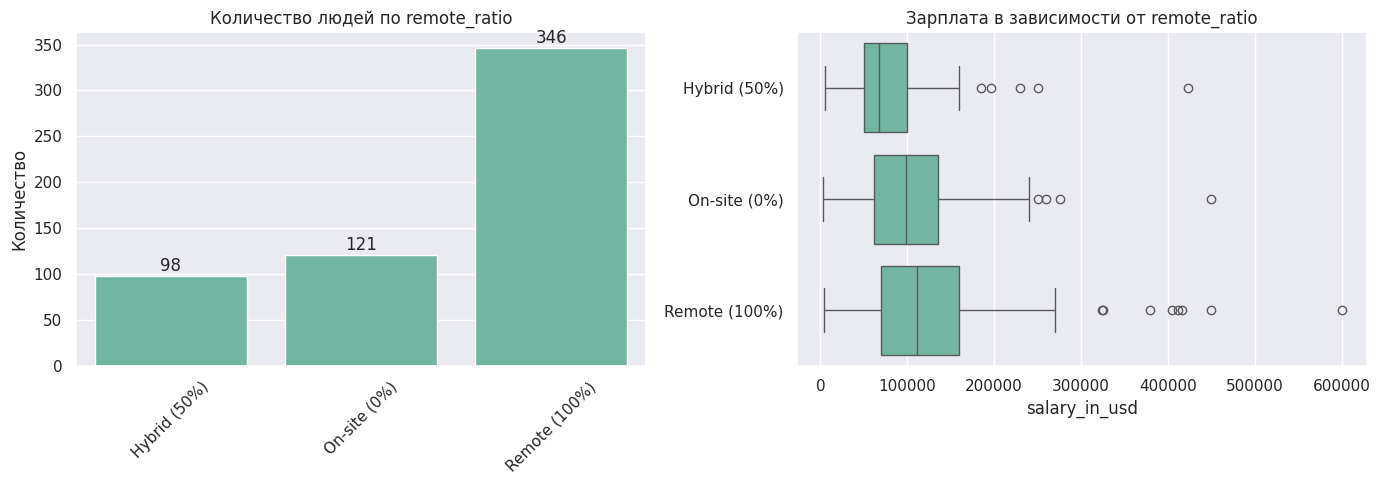

In [47]:
categorical_features = [
    'work_year',
    'experience_level',   
    'employment_type',    
    'job_title',          
    'employee_residence', 
    'company_location',   
    'company_size',       
    'remote_ratio'        
]

explore_categorical_salary_doubleplot(data, categorical_features, top_n=5)

Резимюруем:

- Зависимость зарплаты от года работа:
  - с 2020 по 2022 года средняя и медианная зарплаты увеличиваются год от года (95.8-99.4-123/75.5-82.5-120 в тысячах долларов)
  - количество специалистов в области также увеличивается год от года (72-215-278)

**Вывод:** Распределения зарплат год от года различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от опыта работы experience_level:
  - EN — Entry-level/Junior  - 88 человек в среднем зарабатывают 61.6 с медианой 56.5 тысяч долларов
  - MI — Mid-level/Intermediate - 208 человек в среднем зарабатывают 87.8 с медианой 76.9 тысяч долларов
  - SE — Senior-level/Expert - 243 человека в среднем зарабатывают 138.4 с медианой 135 тысяч долларов
  - EX — Executive-level/Director - 26 человек в среднем зарабатывают 199.4 с медианой 171.4 тысяч долларов

**Вывод:** Распределения зарплат в зависимости от опыта работы различны и показатели увеличиваются с повышением уровня соискателя. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от типа трудоустройста employment_type:
  - PT — неполный рабочий день - 10 человек в среднем зарабатывают 33 с медианой 18.8 тысяч долларов
  - FT — полный рабочий день - 546 человек в среднем зарабатывают 111.8 с медианой 100 тысяч долларов
  - CT — контракт - 5 человек в среднем зарабатывают 184.6 с медианой 105 тысяч долларов
  - FL — фриланс - 4 человек в среднем зарабатывают 48 с медианой 40 тысяч долларов

**Вывод:** Распределения зарплат в зависимости  от типа трудоустройста различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от роли, в которой соискатель работал в течение года job_title:
  - Data Analyst - 82 человек в среднем зарабатывают 90 с медианой 90 тысяч долларов
  - Data Engineer - 121 человек в среднем зарабатывают 109.8 с медианой 100.8 тысяч долларов
  - Data Scientist - 130 человек в среднем зарабатывают 103.3 с медианой 100 тысяч долларов
  - Machine Learning Engineer - 39 человек в среднем зарабатывают 101 с медианой 87.4 тысяч долларов
  - Research Scientist - 16 человек в среднем зарабатывают 184.6 с медианой 105 тысяч долларов
  - Other  - 177 человек в среднем зарабатывают 109 с медианой 76.2 тысяч долларов

**Вывод:** Распределения зарплат у Data Engineer и Data Scientist на первый взгляд не сильно различаются, медианы практически равны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от основной страны проживания сотрудника employee_residence:
  - CA Канада — 27 человек, в среднем зарабатывают 97.2k с медианой 85k долларов
  - DE Германия — 24 человека, в среднем зарабатывают 85.3k с медианой 78k долларов
  - GB Великобритания — 43 человека, в среднем зарабатывают 81.5k с медианой 78.5k долларов
  - IN Индия — 30 человек, в среднем зарабатывают 37.3k с медианой 22.1k долларов
  - US США — 295 человек, в среднем зарабатывают 150.1k с медианой 138k долларов
  - Other — 146 человек, в среднем зарабатывают 61.1k с медианой 52.3k долларов

**Вывод:** Распределения зарплат в зависимости от основной страны проживания сотрудника различаются, сильно выше в США, а самый низкий показатель у Индии. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от страны главного офиса работодателя или филиала по контракту company_location:
  - CA Канада — 28 человек, в среднем получают 100.1k с медианой 81.9k долларов
  - DE Германия — 27 человек, в среднем получают 81.6k с медианой 76.8k долларов
  - GB Великобритания — 46 человек, в среднем получают 81.6k с медианой 78.5k долларов
  - IN Индия — 24 человек, в среднем получают 28.6k с медианой 22.1k долларов
  - US США — 318 человек, в среднем получают 144.3k с медианой 135k долларов
  - Other — 122 человек, в среднем получают 58.7k с медианой 50.1k долларов

**Вывод:** Распределения зарплат в зависимости от страны главного офиса работодателя или филиала по контракту различаются, сильно выше в США, а самый низкий показатель у Индии. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от размера компании company_size:
  - Большая компания (L, >250 сотрудников) — 193 человека, в среднем зарабатывают 118.2k с медианой 100k долларов
  - Средняя компания (M, 50–250 сотрудников) — 290 человек, в среднем зарабатывают 114.8k с медианой 109.6k долларов
  - Маленькая компания (S, <50 сотрудников) — 82 человека, в среднем зарабатывают 77.9k с медианой 65.5k долларов

**Вывод:** Распределения зарплат в зависимости от размера компании у больших и средних компаний различаются не сильно, в то время как в маленьких компаниях гораздо меньше. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

- Зависимость зарплаты от объёма работы, выполняемой удалённо remote_ratio:
  - On-site (0%) — 121 человек, в среднем зарабатывают 105.8k с медианой 98.2k долларов
  - Hybrid (50%) — 98 человек, в среднем зарабатывают 80.7k с медианой 68k долларов
  - Remote (100%) — 346 человек, в среднем зарабатывают 120.8k с медианой 110.7k долларов.

**Вывод:** Распределения зарплат в зависимости от объёма работы, выполняемой удалённо различаются, меньше всего при частично удаленной и максимальные при полностью удаленной, работаю в офисе зарабатывают средне. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## 1.2. Распределение зарплат специалистов Data Scientist по годам

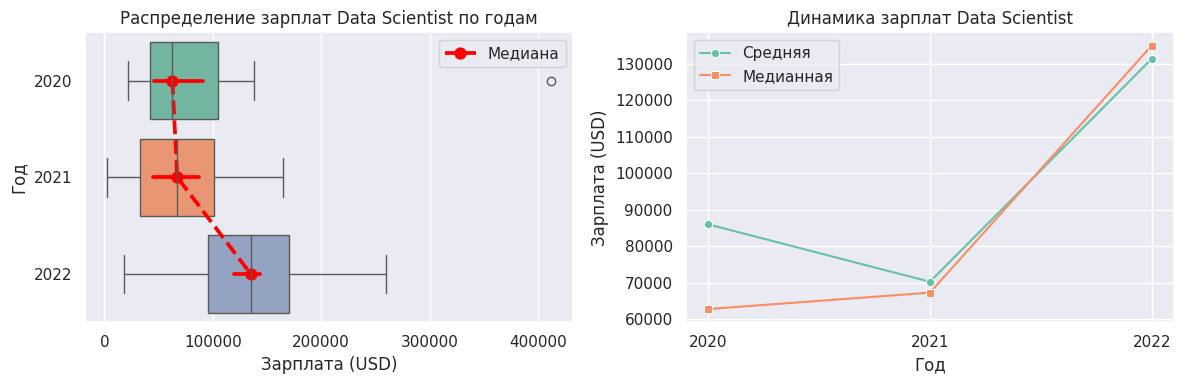

In [185]:
# Фильтруем только Data Scientist
df_ds = data.loc[data['job_title'] == 'Data Scientist']
df_ds['work_year'] = df_ds['work_year'].astype(str)

# --- Считаем статистику ---
df_stats = df_ds.groupby('work_year')['salary_in_usd'].agg(['mean', 'median']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Boxplot по годам ---
sns.boxplot(x='salary_in_usd', y='work_year', data=df_ds, palette="Set2", ax=axes[0])
sns.pointplot(x='salary_in_usd', y='work_year', data=df_ds, estimator='median',
              color='red', markers='o', linestyles='--', label='Медиана', ax=axes[0])
axes[0].set_title("Распределение зарплат Data Scientist по годам")
axes[0].set_ylabel("Год")
axes[0].set_xlabel("Зарплата (USD)")
axes[0].legend()

# --- Линии среднее и медиана ---
sns.lineplot(x='work_year', y='mean', data=df_stats, marker='o', label='Средняя', ax=axes[1])
sns.lineplot(x='work_year', y='median', data=df_stats, marker='s', label='Медианная', ax=axes[1])
axes[1].set_title("Динамика зарплат Data Scientist")
axes[1].set_ylabel("Зарплата (USD)")
axes[1].set_xlabel("Год")
axes[1].legend()

plt.tight_layout()
plt.show()

Видно, что есть один выброс в 2020 году с очень высокой зарплатой, вследствие чего среднее по 2020 году сильно выше медианы. Однако медианы очевидно увеличиваются с каждым годом. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## 1.3. Распределение зарплат Data Scientist и Data Engineer в 2022 году

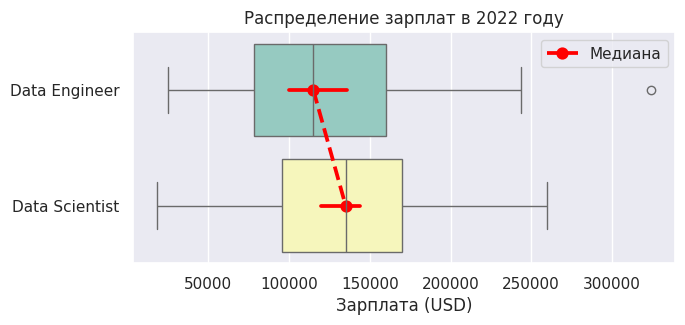

In [ ]:
# Фильтрация только 2022 года и нужных профессий
df_2022 = data[(data['work_year'] == 2022) & 
               (data['job_title'].isin(['Data Scientist', 'Data Engineer']))]

# --- Boxplot ---
plt.figure(figsize=(7, 3))
sns.boxplot(x='salary_in_usd', y='job_title', data=df_2022, palette="Set3")
sns.pointplot(x='salary_in_usd', y='job_title', data=df_2022, estimator='median', 
              color='red', markers='o', linestyles='--', label='Медиана')
plt.title("Распределение зарплат в 2022 году")
plt.ylabel("")
plt.xlabel("Зарплата (USD)")
plt.legend()
plt.show()

У Data Engineer есть одно аномально высокое значение и поменьше разброс значений, однако медиана выше у Data Scientist, как и разброс значений. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## 1.4. Соотношение распределений зарплат специалистов Data Scientist в компаниях различных размеров

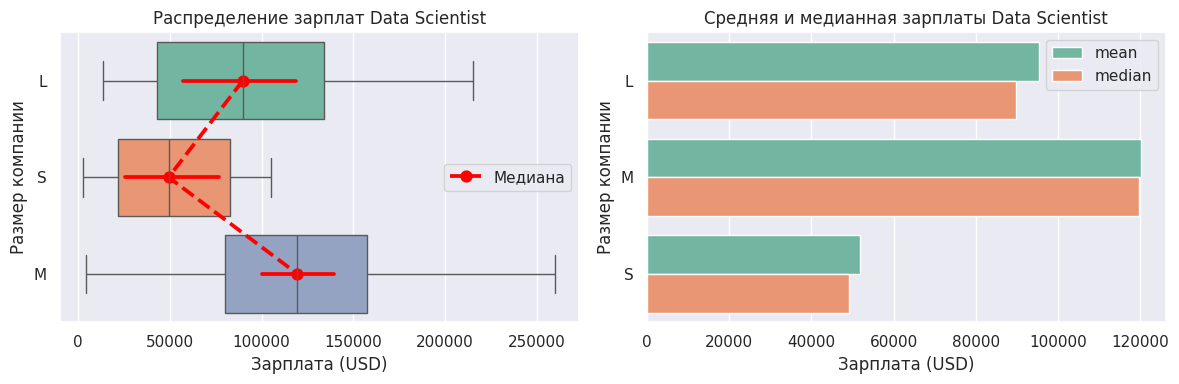

In [184]:
# --- Считаем статистику ---
df_stats_size = df_ds.groupby('company_size')['salary_in_usd'].agg(['mean', 'median']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Boxplot ---
sns.boxplot(x='salary_in_usd', y='company_size', data=df_ds, palette="Set2", ax=axes[0])
sns.pointplot(x='salary_in_usd', y='company_size', data=df_ds, estimator='median',
              color='red', markers='o', linestyles='--', label='Медиана', ax=axes[0])
axes[0].set_title("Распределение зарплат Data Scientist")
axes[0].set_ylabel("Размер компании")
axes[0].set_xlabel("Зарплата (USD)")
axes[0].legend()

# --- Столбчатая диаграмма (среднее и медиана) ---
df_stats_size_melted = df_stats_size.melt(id_vars="company_size", value_vars=["mean", "median"], 
                                          var_name="Метрика", value_name="Зарплата (USD)")

sns.barplot(x='Зарплата (USD)', y='company_size', hue='Метрика', data=df_stats_size_melted, ax=axes[1])
axes[1].set_title("Средняя и медианная зарплаты Data Scientist")
axes[1].set_ylabel("Размер компании")
axes[1].set_xlabel("Зарплата (USD)")
axes[1].legend()

plt.tight_layout()
plt.show()

Самые высокие средние и медианные зарплаты, как и самый высокий разброс в компаниях среднего размера, в маленьких компаниях самые маленькие показатели, но возможно выборки не равны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## 1.5. Соотношение должностей Data Scientist и Data Engineer от размера компании

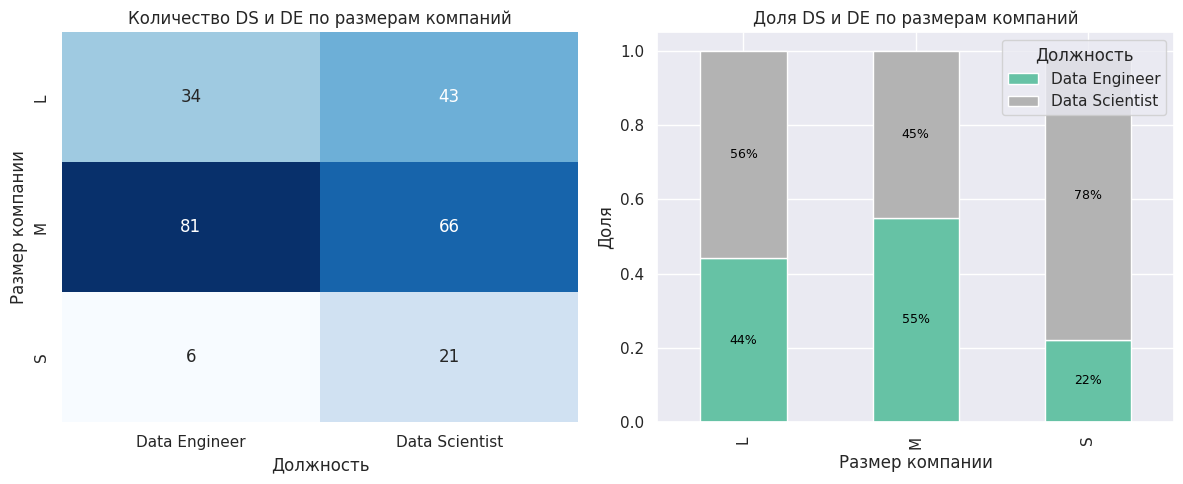

In [ ]:
# Фильтруем только интересующие должности
df_sub = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['company_size'], df_sub['job_title'])

# Таблица с нормировкой (доли)
ct_norm = ct.div(ct.sum(axis=1), axis=0)

# --- Построение 2 графиков рядом ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap (абсолютные значения)
sns.heatmap(ct, annot=True, fmt='d', cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Количество DS и DE по размерам компаний")
axes[0].set_xlabel("Должность")
axes[0].set_ylabel("Размер компании")

# Stacked barplot (доли)
ct_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap="Set2")

# Подписи процентов внутри столбцов
for p in axes[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  
        axes[1].text(x + width/2, y + height/2, f"{height:.0%}", 
                     ha='center', va='center', fontsize=9, color='black')

axes[1].set_title("Доля DS и DE по размерам компаний")
axes[1].set_xlabel("Размер компании")
axes[1].set_ylabel("Доля")
axes[1].legend(title="Должность")

plt.tight_layout()
plt.show()

Согласно данным, в маленьких компаниях инженеров меньше всего, в средних и больших близко к половине. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## 1.6. Соотношение опыта работы experience_level и объемом работы, выполняемой удаленно remote_ratio

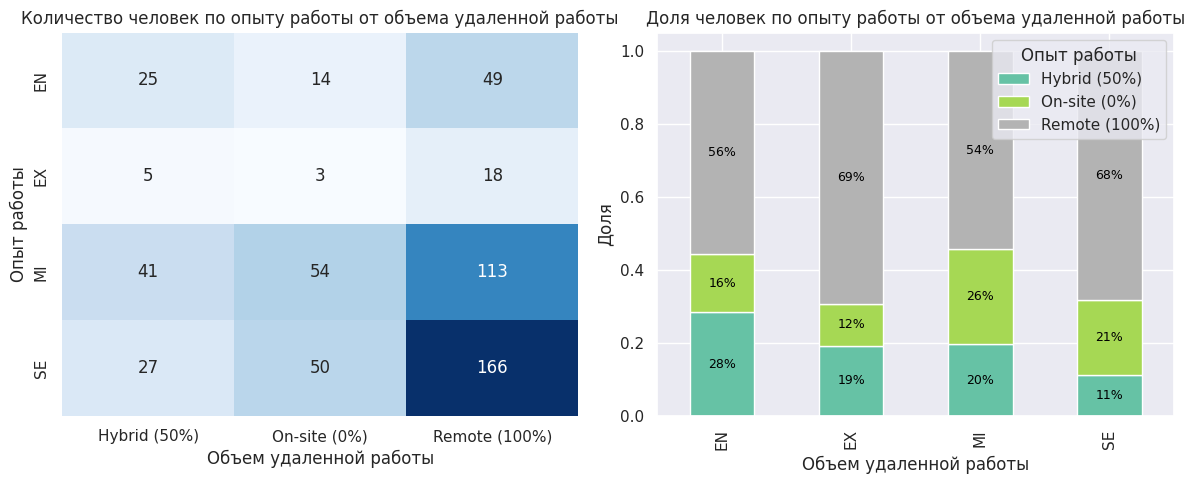

In [154]:
df_sub = data.copy()
df_sub['remote_ratio'] = df_sub['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['experience_level'], df_sub['remote_ratio'])

# Таблица с нормировкой (доли)
ct_norm = ct.div(ct.sum(axis=1), axis=0)

# --- Построение 2 графиков рядом ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap (абсолютные значения)
sns.heatmap(ct, annot=True, fmt='d', cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Количество человек по опыту работы от объема удаленной работы")
axes[0].set_xlabel("Объем удаленной работы")
axes[0].set_ylabel("Опыт работы")

# Stacked barplot (доли)
ct_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap="Set2")

# Подписи процентов внутри столбцов
for p in axes[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  
        axes[1].text(x + width/2, y + height/2, f"{height:.0%}", 
                     ha='center', va='center', fontsize=9, color='black')

axes[1].set_title("Доля человек по опыту работы от объема удаленной работы")
axes[1].set_xlabel("Объем удаленной работы")
axes[1].set_ylabel("Доля")
axes[1].legend(title="Опыт работы")

plt.tight_layout()
plt.show()

С любым опытом работы доля соискателей на полной удаленке гораздо больше, чем при гибридной и в офисе, остальные соотношения различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## 1.7. Соотношение объема удаленной работы по годам

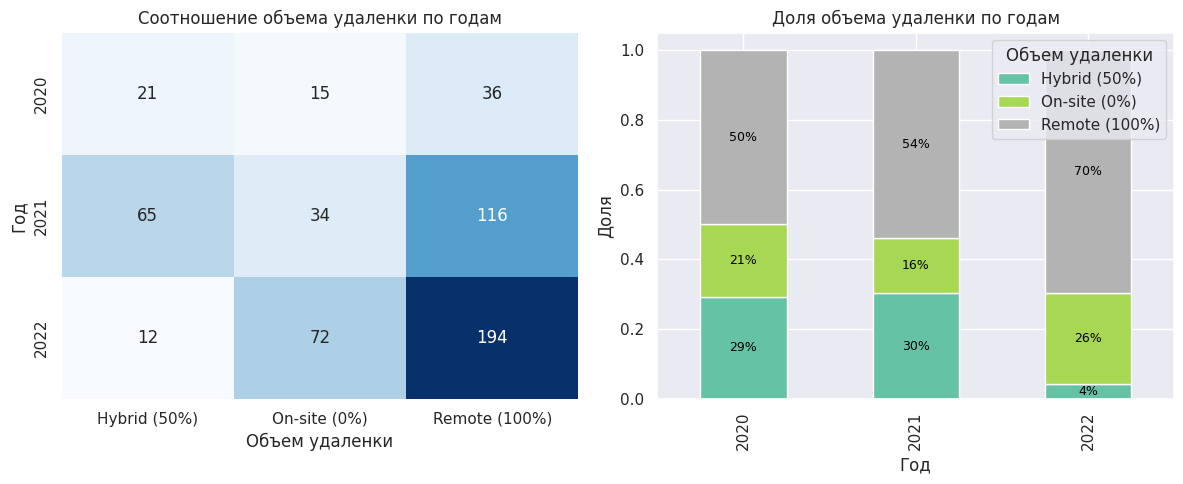

In [194]:
df_sub = data.copy()
df_sub['work_year'] = df_sub['work_year'].astype(str)
df_sub['remote_ratio'] = df_sub['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['work_year'], df_sub['remote_ratio'])

# Таблица с нормировкой (доли)
ct_norm = ct.div(ct.sum(axis=1), axis=0)

# --- Построение 2 графиков рядом ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap (абсолютные значения)
sns.heatmap(ct, annot=True, fmt='d', cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Соотношение объема удаленки по годам")
axes[0].set_xlabel("Объем удаленки")
axes[0].set_ylabel("Год")

# Stacked barplot (доли)
ct_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap="Set2")

# Подписи процентов внутри столбцов
for p in axes[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  
        axes[1].text(x + width/2, y + height/2, f"{height:.0%}", 
                     ha='center', va='center', fontsize=9, color='black')

axes[1].set_title("Доля объема удаленки по годам")
axes[1].set_xlabel("Год")
axes[1].set_ylabel("Доля")
axes[1].legend(title="Объем удаленки")

plt.tight_layout()
plt.show()

Полностью удаленной работы больше всего в 2022 году, а вот гибридной в 2022 стало совсем мало, при том, что офисной стало больше. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## 1.8. Соотношение медианной зарплаты от страны главного офиса работодателя или филиала по контракту

In [189]:
df = data.copy()
converted_country = coco.convert(names=data['company_location'], to="ISO3")
df['company_location'] = converted_country
salary_location = df.groupby(['salary_in_usd','company_location']).size().reset_index()
median = salary_location.groupby('company_location').median().reset_index()

fig = px.choropleth(locations=median['company_location'],
                    color=median['salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.solar,
                    template='plotly_dark',
                    title = 'Median Salary by Company Location')
fig.update_layout(font = dict(size=17,family="Franklin Gothic"), width=900, height=600)
fig.show()

Интересно, что самые большие медианные зарплаты в США и России, в странах Дальнего Востока, Африки и Южной Америки минимальны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

In [190]:
# Посмотрим распределение зарплат по странам работодателям для специальности Data Scientist
df = df_ds.copy()
converted_country = coco.convert(names=df_ds['company_location'], to="ISO3")
df['company_location'] = converted_country
salary_location = df.groupby(['salary_in_usd','company_location']).size().reset_index()
median = salary_location.groupby('company_location').median().reset_index()

fig = px.choropleth(locations=median['company_location'],
                    color=median['salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.solar,
                    template='plotly_dark',
                    title = 'Median Salary Data Scientist by Company Location')
fig.update_layout(font = dict(size=17,family="Franklin Gothic"), width=900, height=600)
fig.show()

В России совсем нет компаний-работодателей для специальности Data Scientist ;(

## 1.9. Соотношение медианной зарплаты от основной страны проживания сотрудника в течение рабочего года 

In [191]:
df = data.copy()
converted_country = coco.convert(names=data['employee_residence'], to="ISO3")
df['employee_residence'] = converted_country
salary_location = df.groupby(['salary_in_usd','employee_residence']).size().reset_index()
median = salary_location.groupby('employee_residence').median().reset_index()

fig = px.choropleth(locations=median['employee_residence'],
                    color=median['salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.solar,
                    template='plotly_dark',
                    title = 'Median Salary by Employee residence')
fig.update_layout(font = dict(size=17,family="Franklin Gothic"), width=900, height=600)
fig.show()

Интересно, насколько различны медианные зарплаты для компаний с офисом в России, и для соискателей, живущих в России, больше чем в 2 раза разница. Либо российские компании чаще нанимают людей из других стран, либо соискатели, живущие в России, работают на компании с офисом в других странах, или комбинация этих вариантов

In [192]:
# Посмотрим распределение зарплат по странам работодателям для специальности Data Scientist
df = df_ds.copy()
converted_country = coco.convert(names=df_ds['employee_residence'], to="ISO3")
df['employee_residence'] = converted_country
salary_location = df.groupby(['salary_in_usd','employee_residence']).size().reset_index()
median = salary_location.groupby('employee_residence').median().reset_index()

fig = px.choropleth(locations=median['employee_residence'],
                    color=median['salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.solar,
                    template='plotly_dark',
                    title = 'Median Salary Data Scientist by Company Location')
fig.update_layout(font = dict(size=17,family="Franklin Gothic"), width=900, height=600)
fig.show()

Судя по тому, что в России нет компаний, нанимающих специалистов Data Scientist, все соискатели по этой специальности, живя в России, работают на иностранные компании

# 2. Статистический анализ данных

## 2.1. Проверка на нормальность и статистическую значимость всех категорий с заработной платой

Для выборок до 5000 объектов используется тест Шапиро — Уилка для проверки на нормальность

Гипотезы в основе теста:

- Нулевая гипотеза: данные распределены нормально.
- Альтернативная гипотеза: данные не распределены нормально.

In [ ]:
def check_categorical_normality_shapiro(df, cat_features, target='salary_in_usd', alpha=0.05, top_n=5):
    """
    Проверка распределения целевой переменной на нормальность по категориям
    с использованием теста Шапиро — Уилка (Shapiro-Wilk).
    
    Если число уникальных значений категориального признака превышает `top_n`,
    то оставшиеся категории объединяются в "Other".

    Параметры
    ----------
    df : pandas.DataFrame
        Исходный DataFrame с данными.
    cat_features : list of str
        Список категориальных признаков.
    target : str, optional, default='salary_in_usd'
        Название целевой переменной.
    alpha : float, optional, default=0.05
        Уровень значимости для проверки нормальности.
    top_n : int, optional, default=5
        Максимальное количество отдельных категорий для проверки.
        Все остальные объединяются в "Other".

    Вывод
    -----
    None
        Для каждой категории выводится p-value и заключение о нормальности.
    """
    df_copy = df.copy()

    # Преобразуем remote_ratio в категорию, если есть и числовой
    if 'remote_ratio' in cat_features and df_copy['remote_ratio'].dtype != 'O':
        df_copy['remote_ratio'] = df_copy['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })
    
    # Преобразуем work_year в строку
    if 'work_year' in cat_features and df_copy['work_year'].dtype != 'O':
        df_copy['work_year'] = df_copy['work_year'].astype(str)

    for cat in cat_features:
        print(f"\nПроверка нормальности для категориального признака: {cat}")
        
        # Если больше top_n категорий — оставляем только топ-N, остальные в Other
        if df_copy[cat].nunique() > top_n:
            top_categories = df_copy[cat].value_counts().nlargest(top_n).index
            df_copy[cat] = df_copy[cat].apply(lambda x: x if x in top_categories else 'Other')
        
        for group, values in df_copy.groupby(cat)[target]:
            if len(values) < 3:
                print(f"\nДля {group}: слишком мало данных для теста")
                continue

            stat, p = shapiro(values)
            print(f"\nДля {group}:")
            print(f"p-value = {p:.3f}")
            if p < alpha:
                print(f"p-значение меньше, чем заданный уровень значимости {alpha}. Распределение отлично от нормального")
            else:
                print(f"p-значение больше, чем заданный уровень значимости {alpha}. Распределение является нормальным")


In [84]:
check_categorical_normality_shapiro(data, categorical_features)


Проверка нормальности для категориального признака: work_year

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Проверка нормальности для категориального признака: experience_level

Для EN:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для EX:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для MI:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Проверка нормальности для к

<img src="https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@DST_EDA_4_8_1.png" alt="" width="1300" align="center" />

**Вывод:**  все распределения отличны от нормальных, мы можем использовать только непараметрические тесты. Кроме того, везде от 3х и более групп, они независимы, следовательно подходящий тест на статистическую значимость **Критерий Краскела — Уоллиса**

- Нулевая гипотеза: Статистически значимых различий между группами нет.

- Альтернативная гипотеза: Различия между группами статистически значимы.

In [161]:
def check_categorical_kruskal(df, cat_features, target='salary_in_usd', alpha=0.05, top_n=5):
    """
    Проверка статистической значимости различий целевой переменной между категориями
    с использованием критерия Краскела — Уоллиса (Kruskal-Wallis).

    Параметры
    ----------
    df : pandas.DataFrame
        Исходный DataFrame с данными.
    cat_features : list of str
        Список категориальных признаков для проверки.
    target : str, optional, default='salary_in_usd'
        Название целевой переменной.
    alpha : float, optional, default=0.05
        Уровень значимости для проверки гипотезы.
    top_n : int, optional, default=5
        Максимальное количество отдельных категорий для проверки.
        Все остальные объединяются в "Other".

    Вывод
    -----
    None
        Для каждого категориального признака выводится p-value и заключение.
    """
    df_copy = df.copy()

    # Преобразуем remote_ratio в категорию, если есть и числовой
    if 'remote_ratio' in cat_features and df_copy['remote_ratio'].dtype != 'O':
        df_copy['remote_ratio'] = df_copy['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })
    
    # Преобразуем work_year в строку
    if 'work_year' in cat_features and df_copy['work_year'].dtype != 'O':
        df_copy['work_year'] = df_copy['work_year'].astype(str)

    for cat in cat_features:
        print(f"\nПроверка статистической значимости для признака: {cat}")

        # Ограничим количество категорий top_n
        if df_copy[cat].nunique() > top_n:
            top_categories = df_copy[cat].value_counts().nlargest(top_n).index
            df_copy[cat] = df_copy[cat].apply(lambda x: x if x in top_categories else 'Other')

        # Собираем значения по группам
        groups = [group[target].values for _, group in df_copy.groupby(cat)]
        
        # Проверяем, достаточно ли данных в группах
        if any(len(g) < 3 for g in groups):
            print("Недостаточно данных для теста в одной или нескольких группах")
            continue

        # Критерий Краскела–Уоллиса
        stat, p = stats.kruskal(*groups)
        print(f"p-value = {p:.3f}")

        if p < alpha:
            print(f"p < {alpha}. Различия между группами статистически значимы.")
        else:
            print(f"p ≥ {alpha}. Статистически значимых различий между группами нет.")


In [159]:
check_categorical_kruskal(data, categorical_features)


Проверка статистической значимости для признака: work_year
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: experience_level
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: employment_type
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: job_title
p-value = 0.024
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: employee_residence
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: company_location
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости для признака: company_size
p-value = 0.000
p < 0.05. Различия между группами статистически значимы.

Проверка статистической значимости д

**Вывод:**

Различия между группами всех признаков с заработной платой статистически значимы

## 2.2. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

In [119]:
df_ds = data.loc[data['job_title'] == 'Data Scientist']
df_ds['work_year'] = df_ds['work_year'].astype(str)

check_categorical_normality_shapiro(df_ds, ['work_year'])


Проверка нормальности для категориального признака: work_year

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `salary_in_usd`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать **Критерий Краскела — Уоллиса**

Сформулируем гипотезы в математическом виде:

- Нулевая гипотеза: зарплаты специалистов Data Scientist в 2020 году ( $\mu_1$ ), в 2021 году ( $\mu_2$ ) и в 2022 году  ( $\mu_3$ ) одинаковые.

$H_0 : \mu_1 = \mu_2 = \mu_3$

- Альтернативная гипотеза: зарплаты специалистов Data Scientist в 2020 году ( $\mu_1$ ), в 2021 году ( $\mu_2$ ) и в 2022 году  ( $\mu_3$ ) не одинаковые.

$H_1 : \mu_1 \neq \mu_2 \neq \mu_3$

**Проведём тест**

In [111]:
# проводим тест
_, p = stats.kruskal(df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2020'], 
                    df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2021'], 
                    df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2022'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

У нас есть основания утверждать, что зарплаты специалистов Data Scientist не одинаковы в разные годы, однако это еще не значит, что они увеличиваются.

Мы можем проверить попарно годы, чтобы проверить, что зарплаты увеличиваются

**Выберем подходящий статистический тест для сравнения 2020 и 2021 годов**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `salary_in_usd`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать **U-критерий Манна — Уитни**


Сформулируем гипотезы в математическом виде:

- Нулевая гипотеза: зарплаты специалистов Data Scientist в 2020 году ( $\mu_1$ ) равны зарплатам в 2021 году ( $\mu_2$ )

$H_0 : \mu_1 = \mu_2$

- Альтернативная гипотеза: распределение значений первой выборки (2020) меньше распределения второй выборки (2021).
 
$H_1 : \mu_1 < \mu_2$

**Проведём тест**

In [125]:
# проводим тест
_, p = stats.mannwhitneyu(df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2020'],
                          df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2021'],
                          alternative='less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Проверим увеличилась ли зарплата в 2022 году по сравнению с 2021**

In [163]:
# проводим тест
_, p = stats.mannwhitneyu(df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2021'],
                          df_ds['salary_in_usd'].loc[df_ds['work_year'] == '2022'],
                          alternative='less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

В 2020 и 2021 годах размеры зарплат не увеличивались, однако в 2022 году по сравнению с 2021 наблюдается рост зарплаты

## 2.3. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [131]:
# Фильтрация только 2022 года и нужных профессий
df_2022 = data[(data['work_year'] == 2022) & (data['job_title'].isin(['Data Scientist', 'Data Engineer']))]

check_categorical_normality_shapiro(df_2022, ['job_title'])


Проверка нормальности для категориального признака: job_title

Для Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `salary_in_usd`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.


Для проверки нашей гипотезы можно использовать **U-критерий Манна — Уитни**


Сформулируем гипотезы в математическом виде:

- Нулевая гипотеза: зарплаты специалистов Data Scientist ( $\mu_1$ ) равны зарплатам специалистов Data Engineer ( $\mu_2$ )

$H_0 : \mu_1 = \mu_2$

- Альтернативная гипотеза: зарплаты специалистов Data Scientist больше зарплат специалистов Data Engineer
 
$H_1 : \mu_1 > \mu_2$

**Проведём тест**

In [135]:
# проводим тест
_, p = stats.mannwhitneyu(df_2022['salary_in_usd'].loc[df_2022['job_title'] == 'Data Scientist'],
                          df_2022['salary_in_usd'].loc[df_2022['job_title'] == 'Data Engineer'],
                          alternative='greater')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Зарплаты специалистов Data Scientist и Data Engineer в 2022 году статистически не различаются

## 2.4. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

In [142]:
# уберем выброс
df_ds = df_ds.loc[df_ds['salary_in_usd'] < 400000]
# проверим на нормальность
check_categorical_normality_shapiro(df_ds, ['company_size'])


Проверка нормальности для категориального признака: company_size

Для L:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [143]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'], 
                    df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                    df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

Тест на равенство дисперсий
p-value = 0.035
Дисперсии не одинаковы, нужно использовать непараметрический тест


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `salary_in_usd`? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — да.
* Дисперсии равны? - нет

Для проверки нашей гипотезы можно использовать **Критерий Краскела — Уоллиса**

Сформулируем гипотезы в математическом виде:

- Нулевая гипотеза: зарплаты специалистов Data Scientist в маленьких ( $\mu_1$ ), средних ( $\mu_2$ ) и больших  ( $\mu_3$ ) одинаковые.

$H_0 : \mu_1 = \mu_2 = \mu_3$

- Альтернативная гипотеза: зарплаты специалистов Data Scientist в маленьких ( $\mu_1$ ), средних ( $\mu_2$ ) и больших  ( $\mu_3$ ) не одинаковые.

$H_1 : \mu_1 \neq \mu_2 \neq \mu_3$

**Проведём тест**

In [138]:
# проводим тест
_, p = stats.kruskal(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'], 
                    df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                    df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Распределения зарплат специалистов Data Scientist в компаниях различных размеров статистически различно.

Как именно (где больше зарплата) они соотносятся, мы можем проверить, если сравним их попарно


**Выберем подходящий статистический тест для сравнения маленьких S и средних M компаний**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `salary_in_usd`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать **Двухвыборочный t-критерий (t-test)**


Сформулируем гипотезы в математическом виде:

- Нулевая гипотеза: зарплаты специалистов Data Scientist в средних M ( $\mu_1$ ) меньше или равны зарплатам в маленьких S ( $\mu_2$ )

$H_0 : \mu_1 \leq \mu_2$

- Альтернативная гипотеза: зарплаты специалистов Data Scientist в средних M ( $\mu_1$ ) больше зарплат в маленьких S ( $\mu_2$ )
 
$H_1 : \mu_1 > \mu_2$

**Проведём тест**

In [141]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                      df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                       df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'], 
                       alternative='greater', equal_var=False)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Тест на равенство дисперсий
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Проведем статистический тест для сравнения маленьких S и больших L компаний**

In [145]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'], 
                      df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'], 
                       df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'S'], 
                       alternative='greater', equal_var=False)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Тест на равенство дисперсий
p-value = 0.008
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Проведем статистический тест для сравнения больших L и средних M компаний**

In [147]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                      df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'M'], 
                       df_ds['salary_in_usd'].loc[df_ds['company_size'] == 'L'], 
                       alternative='greater', equal_var=False)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Тест на равенство дисперсий
p-value = 0.825
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.014
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:**

Зарплаты в компаниях средних размеров статистически больше, чем в маленьких и больших.

Зарплаты в компаниях больших размеров статистически больше, чем в маленьких, но меньше, чем в средних.

## 2.5. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [151]:
# Фильтруем только интересующие должности
df_sub = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['company_size'], df_sub['job_title'])

ct

job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


In [152]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(ct)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании

## 2.6. Есть ли связь между опытом работы experience_level и объемом работы, выполняемой удаленно remote_ratio

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между опытом работы experience_level и объемом работы, выполняемой удаленно remote_ratio нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между опытом работы experience_level и объемом работы, выполняемой удаленно remote_ratio есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признаков? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [155]:
df_sub = data.copy()
df_sub['remote_ratio'] = df_sub['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['experience_level'], df_sub['remote_ratio'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(ct)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Существует статистически значимая взаимосвязь между опытом работы experience_level и объемом работы, выполняемой удаленно remote_ratio

## 2.7. Изменяется ли объем работы, выполняемой удаленно с каждым годом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: объем работы, выполняемой удаленно remote_ratio с каждым годом не меняется (признаки независимы).

*Альтернативная гипотеза*: объем работы, выполняемой удаленно remote_ratio с каждым годом не меняется (признаки независимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признаков? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [195]:
df_sub = data.copy()
df_sub['work_year'] = df_sub['work_year'].astype(str)
df_sub['remote_ratio'] = df_sub['remote_ratio'].map({
            0: 'On-site (0%)',
            50: 'Hybrid (50%)',
            100: 'Remote (100%)'
        })

# Таблица сопряженности (кол-ва)
ct = pd.crosstab(df_sub['work_year'], df_sub['remote_ratio'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(ct)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Существует статистически значимая разница объема работы, выполняемой удаленно с каждым годом

# 3. Итоговые результаты исследования

- Различия между группами всех признаков с заработной платой статистически значимы
- Нет статистической разницы между зарплатами в 2020 и 2021 годах, однако в 2022 году по сравнению с 2021 наблюдается рост зарплаты
- Зарплаты специалистов Data Scientist и Data Engineer в 2022 году статистически не различаются
- Зарплаты в компаниях средних размеров статистически больше, чем в маленьких и больших
- Зарплаты в компаниях больших размеров статистически больше, чем в маленьких, но меньше, чем в средних
- Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании
- Существует статистически значимая взаимосвязь между опытом работы experience_level и объемом работы, выполняемой удаленно remote_ratio
- Существует статистически значимая разница объема работы, выполняемой удаленно с каждым годом